<a href="https://colab.research.google.com/github/Summit2/ML_education/blob/main/%D0%92%D0%B8%D0%BA%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%A4%D1%80%D0%BE%D0%BB%D0%BE%D0%B2%D0%B0_35951873.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework. Image classification.

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них по отдельности.

Логин на кагле (just in case): vafrolova2

Скор финальный: **0.99681**


## Installing dependencies. Setting device. Unzipping data  

In [ ]:
!pip install -q transformers>4.0.0

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup

import PIL
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
from multiprocessing.pool import ThreadPool

from PIL import Image
import seaborn as sns
import matplotlib.patches as patches
from matplotlib import colors, pyplot as plt
from matplotlib.font_manager import FontProperties

%matplotlib inline

# будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print(f'PIL version {PIL.__version__}')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


PIL version 9.5.0


In [ ]:
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU.')
else:
    print('CUDA is available!  Training on GPU.')

CUDA is available!  Training on GPU.


In [ ]:
!nvidia-smi

Sun Nov 12 11:32:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [ ]:
from google.colab import drive # comment this line if use kaggle instead of colab
drive.mount('/content/gdrive/') # comment this line if use kaggle instead of colab

In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip # comment this line if use kaggle instead of colab
!ls train

## Preparing train/val/test datasets \& dataloaders

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/') # '/kaggle/input/journey-springfield-zip/train' - if use kaggle instead of colab
TEST_DIR = Path('./testset') # '/kaggle/input/journey-springfield-zip/testset' - same

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

cuda


In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

In [ ]:
n_classes = len(np.unique(train_val_labels))
print("# of classes: {}".format(n_classes))

# of classes: 42


Ниже мы используем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet.


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample).

[general info about preprocessing using torchvision](https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/
)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
batch_size = 64
test_size = 0.2

train_files, val_files = train_test_split(
    train_val_files,
    test_size=test_size,
    stratify=train_val_labels,
    random_state=42,
)

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode="test")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Давайте посмотрим на наших героев.

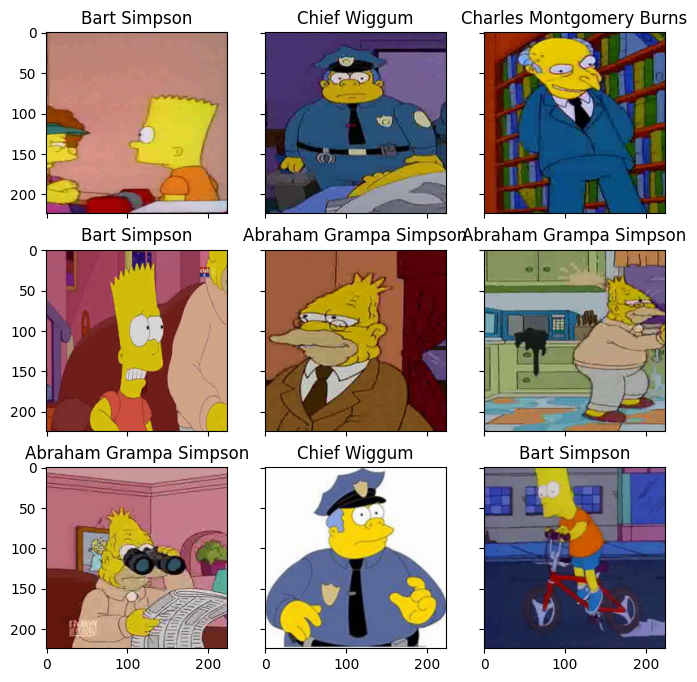

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))

    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(
        im_val.data.cpu(),
        title=img_label,
        plt_ax=fig_x,
    )

Можете добавить ваши любимые сцены и классифицировать их. (весёлые результаты можно кидать в чат).

## Transfer learning


In [ ]:
def get_resnext_for_transfer_learning(n_classes: int, device=DEVICE):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(2048, 2048),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(2048, n_classes),
    )
    model = model.to(device)
    return model

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, device=DEVICE):
    model.train()

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        preds = torch.argmax(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

        running_loss += loss.item() * inputs.size(0)

        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion, device=DEVICE):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_loader, val_loader, model, epochs, lr):
    history = []
    log_template = "\nEpoch {ep:03d} | train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} | train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="Epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()
        opt = torch.optim.AdamW(model.parameters(), lr=lr)
        scheduler = get_linear_schedule_with_warmup(
            opt,
            num_warmup_steps=0,
            num_training_steps=len(train_loader) * epochs
        )

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("Train Loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            pbar_outer.update(1)

    return history

In [ ]:
def predict(model, test_loader, device=DEVICE):
    model.eval()

    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)

            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Определим модель и запустим её обучение.

In [ ]:
model = get_resnext_for_transfer_learning(n_classes)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 224MB/s] 


In [ ]:
lr = 3e-4
epochs = 10

history = train(
    train_loader,
    val_loader,
    model=model,
    epochs=epochs,
    lr=lr,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loss 0.5690287673959563


Epoch:  10%|█         | 1/10 [08:56<1:20:28, 536.49s/it]


Epoch 001 | train_loss: 0.5690     val_loss 0.2361 | train_acc 0.8643 val_acc 0.9405
Train Loss 0.17326610257666014


Epoch:  20%|██        | 2/10 [15:51<1:01:58, 464.86s/it]


Epoch 002 | train_loss: 0.1733     val_loss 0.1814 | train_acc 0.9543 val_acc 0.9556
Train Loss 0.09065269642169937


Epoch:  30%|███       | 3/10 [22:41<51:19, 440.00s/it]  


Epoch 003 | train_loss: 0.0907     val_loss 0.1632 | train_acc 0.9768 val_acc 0.9606
Train Loss 0.06961398179568666


Epoch:  40%|████      | 4/10 [29:30<42:45, 427.59s/it]


Epoch 004 | train_loss: 0.0696     val_loss 0.1268 | train_acc 0.9809 val_acc 0.9701
Train Loss 0.04120775648030908


Epoch:  50%|█████     | 5/10 [36:19<35:05, 421.12s/it]


Epoch 005 | train_loss: 0.0412     val_loss 0.1059 | train_acc 0.9885 val_acc 0.9775
Train Loss 0.022055962301332895


Epoch:  60%|██████    | 6/10 [43:08<27:48, 417.01s/it]


Epoch 006 | train_loss: 0.0221     val_loss 0.1017 | train_acc 0.9944 val_acc 0.9771
Train Loss 0.012940034213281566


Epoch:  70%|███████   | 7/10 [49:56<20:42, 414.01s/it]


Epoch 007 | train_loss: 0.0129     val_loss 0.0989 | train_acc 0.9961 val_acc 0.9790


Epoch:  80%|████████  | 8/10 [56:43<13:43, 411.67s/it]


Epoch 008 | train_loss: 0.0074     val_loss 0.0894 | train_acc 0.9979 val_acc 0.9816
Train Loss 0.0029466769476558545


Epoch:  90%|█████████ | 9/10 [1:03:34<06:51, 411.39s/it]


Epoch 009 | train_loss: 0.0029     val_loss 0.0826 | train_acc 0.9994 val_acc 0.9838
Train Loss 0.0015605248040101432


Epoch: 100%|██████████| 10/10 [1:10:34<00:00, 423.48s/it]


Epoch 010 | train_loss: 0.0016     val_loss 0.0824 | train_acc 0.9998 val_acc 0.9835


In [ ]:
# torch.save(model.state_dict(), 'ResNext_finetuned_42.pth')

In [ ]:
# model.load_state_dict(torch.load('ResNext_finetuned_42.pth'))

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

Построим кривые обучения.

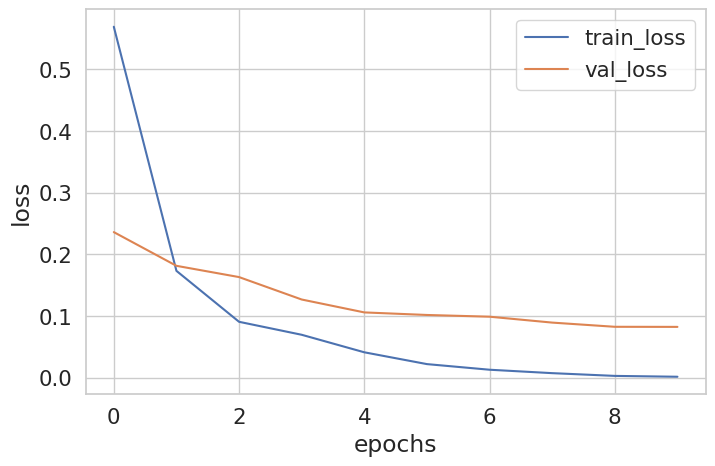

In [ ]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

<img src="https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg" width="300" height="200" />


Хорошо бы понять, как сделать submit. У нас есть сеть и её метод eval, который позволяет перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, который позволяет получить вектор вероятностей, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание для одной картинки"""
    model.eval()

    with torch.no_grad():
        inputs = inputs.to(device)

        logits = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 500)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims, -1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
f1_weighted = f1_score(actual_labels, y_pred, average='weighted')
f1_micro = f1_score(actual_labels, y_pred, average='micro')
f1_macro = f1_score(actual_labels, y_pred, average='macro')

print("F1 score weighted:", f1_weighted)
print("F1 score micro:", f1_micro)
print("F1 score macro:", f1_macro)

F1 score weighted: 0.9895689128376959
F1 score micro: 0.984
F1 score macro: 0.712409686006172


Сделаем классную визуализацию,  чтобы посмотреть, насколько сеть уверена в своих ответах.

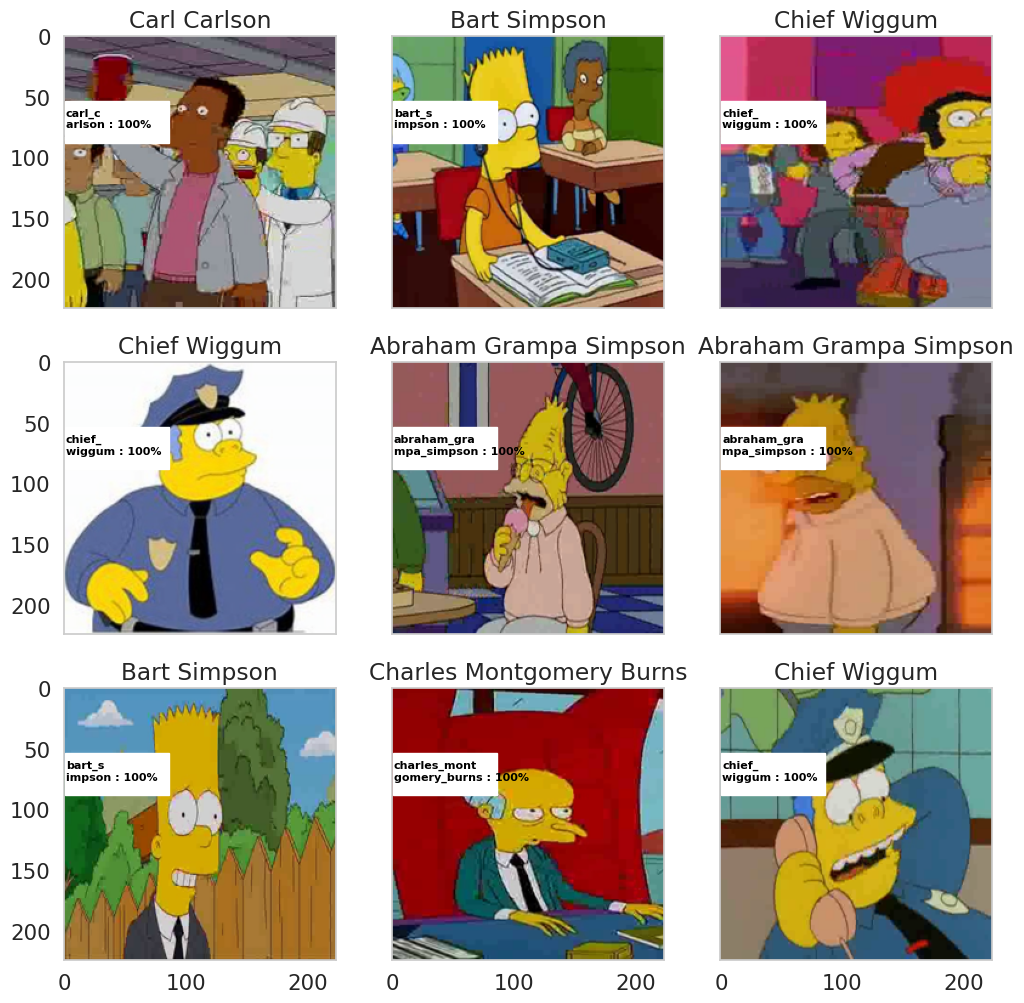

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла распознать. Изучите данную проблему, это понадобится в дальнейшем.

## Submit на Kaggle

<img src="https://i.redd.it/nuaphfioz0211.jpg" width="200" height="200" />

In [ ]:
probs = predict(model, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd

my_submit = pd.read_csv("/content/sample_submission.csv") # '/kaggle/input/journey-springfield-zip/sample_submission.csv' # if use kaggle instead of colab
my_submit = pd.DataFrame(
    {
        'Id': test_filenames,
        'Expected': preds,
    }
)

my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('resnext_solution.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!
